In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

**Read Data**

In [2]:
data = pd.read_csv("/content/olid-training-v1.0.tsv", sep="\t")
data.drop(["subtask_a", "subtask_c"], axis=1, inplace=True)
data.head()

,id,tweet,subtask_b
0,86426,@USER She should ask a few native Americans wh...,UNT
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
2,16820,Amazon is investigating Chinese employees who ...,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NaN


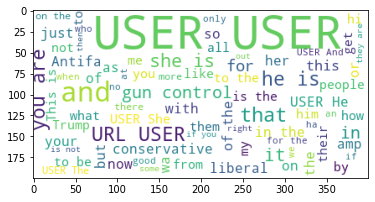

In [3]:
from wordcloud import WordCloud

texts = " ".join([x for x in data["tweet"].values])

wordcloud = WordCloud(background_color ='white', stopwords={}, min_font_size = 10).generate(texts)

plt.imshow(wordcloud)
plt.show()

**Data tag distribution**

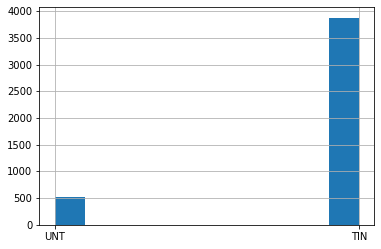

In [4]:
data.subtask_b.hist()

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**Remove Stopwords and convert special decontract words**

In [6]:
from nltk.corpus import stopwords
import re
from tqdm import tqdm

http_stopwords = ["br", "http", "https", "span", "@USER", "URL", "user", "url"]
STOPWORDS = http_stopwords + list(stopwords.words("english"))
STOPWORDS = set(STOPWORDS)

# preprocessing the text features by removing the short forms, stopwords, numbers

def decontract_and_clean(phrase):
    # specific
    phrase = re.sub("[^a-zA-Z]",  " ", str(phrase))
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = ' '.join(e for e in phrase.split() if e.lower() not in STOPWORDS)
    return phrase

# Combining all the relevant codes for processing of text data
#remove spacial character

def clean(df_sentences):
    clean_text_list = []
    # tqdm is for printing the status bar
    for sentance in tqdm(df_sentences.values):
        sentance = decontract_and_clean(sentance)
        clean_text_list.append(sentance.lower().strip())
    
    return clean_text_list

from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

**Plot results**

In [7]:

def view_graphs(history):
    metrics = list(history.history.keys())
    def plot(metric):
      plt.plot(history.history[metric])
      plt.plot(history.history['val_' + metric], '')
      plt.xlabel("Epochs")
      plt.ylabel(metric)
      plt.legend([metric, 'val_' + metric])

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot(metrics[0])
    plt.subplot(1, 2, 2)
    plot(metrics[1])
    plt.show()

**Clean Data**

In [8]:
data["tweet"] = clean(data["tweet"])
data.head()

100%|██████████| 13240/13240 [00:00<00:00, 25102.46it/s]


,id,tweet,subtask_b
0,86426,ask native americans take,UNT
1,90194,go home drunk maga trump,TIN
2,16820,amazon investigating chinese employees selling...,NaN
3,62688,someone vetaken piece shit volcano,UNT
4,43605,obama wanted liberals amp illegals move red st...,NaN


**Observe Wordcloud**

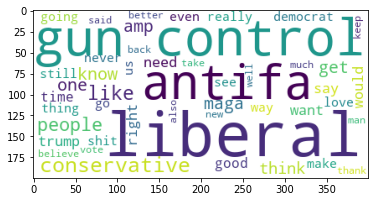

In [9]:
from wordcloud import WordCloud

texts = " ".join([x for x in data["tweet"].values])

wordcloud = WordCloud(background_color ='white', stopwords={}, min_font_size = 10).generate(texts)

plt.imshow(wordcloud)
plt.show()

**Lemmatization and Stemming**

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

lemmatizer = WordNetLemmatizer()
stemmer = LancasterStemmer()
data["tweet"] = data["tweet"].apply(lemmatizer.lemmatize)
data["tweet"] = data["tweet"].apply(stemmer.stem)

X = data["tweet"]
y = data["subtask_b"]

**Split data for Training and testing sets**

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=43)

**Encode Outputs**

In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train = y_train.apply(lambda x: 1 if x == "TIN" else (0 if x == 'UNT' else 2))
y_test = y_test.apply(lambda x: 1 if x == "TIN" else (0 if x == 'UNT' else 2))
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
y_train_one_hot = encoder.fit_transform(np.array(y_train)).toarray()
y_test_one_hot = encoder.transform(np.array(y_test)).toarray()
y_test_one_hot

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

**Encode Inputs**

In [13]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

vocab_length = 1000
max_len = max(len(max(X_train,key=lambda x:len(x))),
              len(max(X_test,key=lambda x:len(x))))

X_train_one_hot = [one_hot(x, vocab_length) for x in X_train]
X_train_one_hot = pad_sequences(X_train_one_hot, maxlen=max_len, padding='post')

X_test_one_hot = [one_hot(x, vocab_length) for x  in X_test]
X_test_one_hot = pad_sequences(X_test_one_hot, maxlen=max_len, padding='post')

In [ ]:
print(X_test_one_hot)

[[545 103  76 ...   0   0   0]
 [649 664 726 ...   0   0   0]
 [257 895 803 ...   0   0   0]
 ...
 [428 807 893 ...   0   0   0]
 [813  21 119 ...   0   0   0]
 [852   5   3 ...   0   0   0]]


In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D,LSTM,Dropout,Flatten,Reshape,GRU

**Define f1 metrics to calculate model accuracy of unbalanced data**

In [18]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision * recall)/(precision+recall+K.epsilon())
    return f1_val

**Create Convolution Model**

In [19]:
model = Sequential([
Embedding(vocab_length, 30, input_length=max_len,mask_zero=True),
Convolution1D(32,5,activation="relu"),
Dropout(0.7),
Convolution1D(16,3,activation="relu"),
Dropout(0.6),
MaxPooling1D(5),
Flatten(),
Dense(y_train_one_hot.shape[1],activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 253, 30)           30000     
                                                                 
 conv1d (Conv1D)             (None, 249, 32)           4832      
                                                                 
 dropout (Dropout)           (None, 249, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 247, 16)           1552      
                                                                 
 dropout_1 (Dropout)         (None, 247, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                        

**Run Model**

Epoch 1/10
927/927 [==============================] - 12s 12ms/step - loss: 0.7797 - accuracy: 0.6663 - val_loss: 0.9178 - val_accuracy: 0.6161
Epoch 2/10
927/927 [==============================] - 10s 11ms/step - loss: 0.7464 - accuracy: 0.6768 - val_loss: 0.8457 - val_accuracy: 0.6863
Epoch 3/10
927/927 [==============================] - 11s 12ms/step - loss: 0.6723 - accuracy: 0.7181 - val_loss: 0.7955 - val_accuracy: 0.6979
Epoch 4/10
927/927 [==============================] - 10s 11ms/step - loss: 0.6486 - accuracy: 0.7316 - val_loss: 0.8035 - val_accuracy: 0.6913
Epoch 5/10
927/927 [==============================] - 11s 12ms/step - loss: 0.6457 - accuracy: 0.7365 - val_loss: 0.7825 - val_accuracy: 0.6866
Epoch 6/10
927/927 [==============================] - 11s 12ms/step - loss: 0.6114 - accuracy: 0.7526 - val_loss: 0.7574 - val_accuracy: 0.6944
Epoch 7/10
927/927 [==============================] - 11s 12ms/step - loss: 0.5816 - accuracy: 0.7668 - val_loss: 0.7583 - val_accuracy:

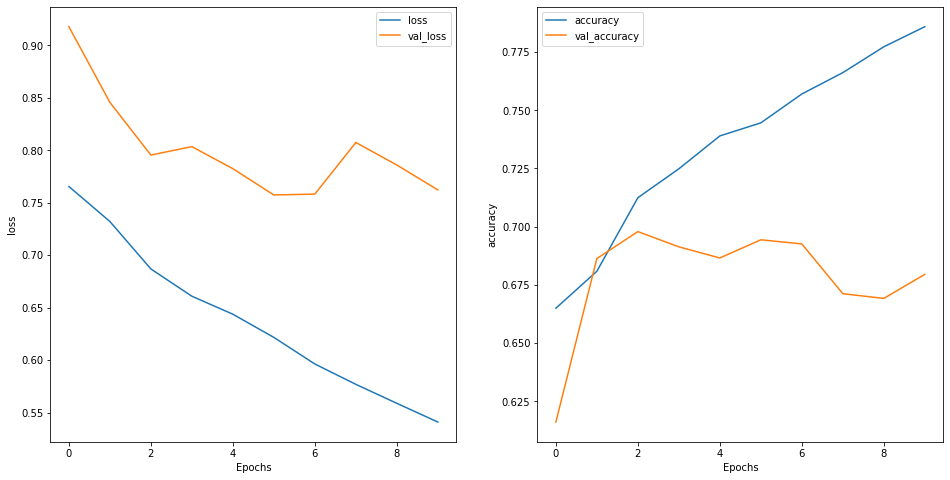

In [ ]:
history = model.fit(X_train_one_hot, y_train_one_hot, validation_data=(X_test_one_hot, y_test_one_hot), epochs=10, batch_size=10, shuffle=True) # validation set
view_graphs(history)

**Find Accuracy**

In [ ]:
_, accuracy = model.evaluate(X_test_one_hot, y_test_one_hot)

125/125 [==============================] - 1s 11ms/step - loss: 0.8415 - get_f1: 0.6344


**Predict**

In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test_one_hot)
print(y_predict[-1])

[0.12802902 0.7936059  0.07836509]


In [ ]:
predict = pd.read_csv("/content/testset-levelb.tsv", sep="\t")
predict.head()
predict["tweet"]

predict["tweet"] = clean(predict["tweet"])
predict["tweet"] = predict["tweet"].apply(lemmatizer.lemmatize)
predict["tweet"] = predict["tweet"].apply(stemmer.stem)

X_predict_one_hot = [one_hot(x, vocab_length) for x  in predict["tweet"]]
X_predict_one_hot = pad_sequences(X_predict_one_hot, maxlen=max_len, padding='post')

100%|██████████| 240/240 [00:00<00:00, 21448.30it/s]


In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_predict_one_hot)
print(y_predict[-1])

[0.0730977  0.8222527  0.10464957]


**Create LSTM Model**

In [20]:
model = Sequential([
Embedding(vocab_length, 30, input_length=max_len,mask_zero=True),
LSTM(128, return_sequences=True),
Dropout(0.7),
LSTM(64),
Dropout(0.6),
Dense(max_len, activation='relu'),
Flatten(),
Dense(y_train_one_hot.shape[1], activation='softmax'),               
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=get_f1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 253, 30)           30000     
                                                                 
 lstm (LSTM)                 (None, 253, 128)          81408     
                                                                 
 dropout_2 (Dropout)         (None, 253, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 253)               16445     
                                                                 
 flatten_1 (Flatten)         (None, 253)              

**Run LSTM MOdel**

Epoch 1/10
927/927 [==============================] - 457s 485ms/step - loss: 0.7971 - get_f1: 0.5901 - val_loss: 0.7106 - val_get_f1: 0.6796
Epoch 2/10
927/927 [==============================] - 448s 483ms/step - loss: 0.6795 - get_f1: 0.6873 - val_loss: 0.7183 - val_get_f1: 0.6754
Epoch 3/10
927/927 [==============================] - 446s 481ms/step - loss: 0.6480 - get_f1: 0.7008 - val_loss: 0.7303 - val_get_f1: 0.6504
Epoch 4/10
927/927 [==============================] - 443s 478ms/step - loss: 0.6142 - get_f1: 0.7183 - val_loss: 0.7101 - val_get_f1: 0.6590
Epoch 5/10
927/927 [==============================] - 444s 479ms/step - loss: 0.5965 - get_f1: 0.7303 - val_loss: 0.7367 - val_get_f1: 0.6457
Epoch 6/10
927/927 [==============================] - 446s 481ms/step - loss: 0.5702 - get_f1: 0.7388 - val_loss: 0.7725 - val_get_f1: 0.6566
Epoch 7/10
927/927 [==============================] - 452s 488ms/step - loss: 0.5352 - get_f1: 0.7531 - val_loss: 0.7919 - val_get_f1: 0.6225
Epoch 

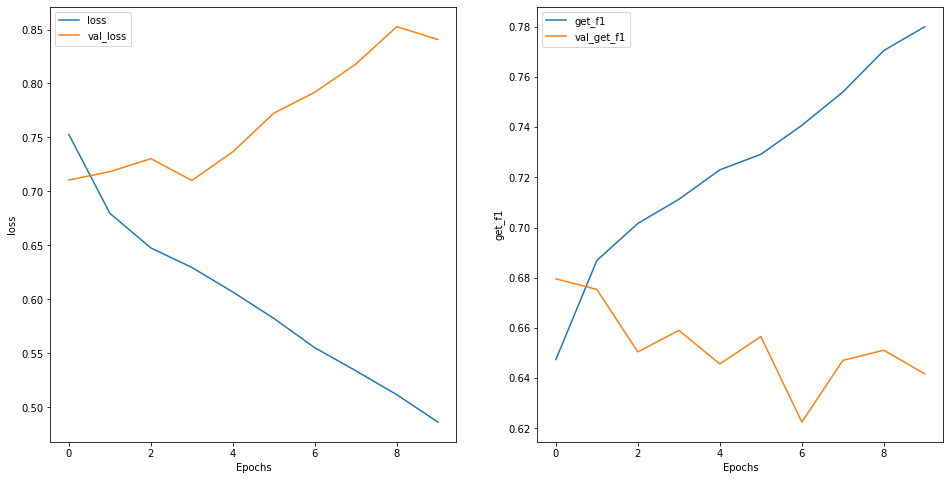

In [ ]:
history = model.fit(X_train_one_hot, y_train_one_hot, validation_data=(X_test_one_hot, y_test_one_hot), epochs=10, batch_size=10, shuffle=True) # validation set
view_graphs(history)

In [ ]:
_, accuracy = model.evaluate(X_test_one_hot, y_test_one_hot)
print('Accuracy: %.2f' % (accuracy*100))

125/125 [==============================] - 17s 139ms/step - loss: 0.8408 - get_f1: 0.6442
Accuracy: 64.42


In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test_one_hot)
print(y_predict[-1])

[0.00141649 0.5602956  0.43828788]
